# Evaluate the Void Growth over Time
Use our matched voids to show a few things about how voids move and change. 
Involves both looking at the entire trajectory and individual points along the line

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colormaps
from scipy.interpolate import UnivariateSpline
from pathlib import Path
import pandas as pd
import numpy as np

Configuration

In [2]:
run_directory = '../data/8bitTIFF-video37-525C/'
pixel_size = 0.47  # nm/pixel

In [3]:
run_directory = Path(run_directory)
run_name = run_directory.name
defect_path = f'../0_drift-correction/output/{run_name}/defect-details.json'
out_directory = Path('output') / run_name
track_path = out_directory / 'tracks.json'

In [4]:
(out_directory / 'figures').mkdir(exist_ok=True)

## Load in the Void Data
Load in the void tracks from a previous notebook and the overall summaries in each

In [5]:
void_tracks = pd.read_json(track_path, lines=True)
void_tracks.head(2)

,start_frame,end_frame,total_frames,inferred_frames,positions,local_id,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate,radii,max_radius,min_radius,growth_rate
0,0,185,186,15,"[[481.8997289973, 35.6449864499], [481.2091905...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.8824431987, 0.2779384414, 1.1058932439...",18.996284,0.102131,"[0.0, 0.8824431987, 1.7246221977, 2.6025893041...",216.028566,1.161444,"[10.8377279908, 10.4489373125, 10.4641579139, ...",12.283277,4.145930,-0.030150
1,0,347,348,6,"[[38.9777777778, 977.7616161616], [38.27034154...","[20, 19, 19, 21, 19, 19, 21, 21, 20, 18, 20, 1...","[0.0, 0.8318213484, 1.3409932184, 0.9247606544...",20.133153,0.057854,"[0.0, 0.8318213484, 1.800065677, 2.94466081030...",432.409287,1.242555,"[12.5524258078, 12.8159237385, 12.9395131335, ...",13.505242,4.478116,-0.017284


In [6]:
frame_data = pd.read_json(defect_path, lines=True)
frame_data.head(2)

,void_frac,void_count,radii,radii_average,positions,run_time,created_time,completed_time,mask-path,image-path,rtt,detect_time,positions_corrected-fft,drift,positions_corrected-track
0,0.008362,21,"[10.8377279908, 11.3540963491, 4.0684289451, 7...",10.759124,"[[481.8997289973, 35.6449864499], [153.7308641...",0.205832,2022-06-21 15:13:23,2023-07-28 15:20:13.962,8bitTIFF-video37-525C/masks/Vedio37-525C-Minut...,8bitTIFF-video37-525C/Vedio37-525C-Minute_00_S...,184.039445,2023-07-28 15:17:09.923,"[[481.8997289973, 35.6449864499], [153.7308641...","[0.0, 0.0]","[[481.8997289973, 35.6449864499], [153.7308641..."
1,0.008348,20,"[10.4489373125, 10.7196020874, 4.5135166684, 7...",11.116372,"[[481.2973760933, 35.7346938776], [154.0526315...",0.213394,2022-06-21 15:13:23,2023-07-28 15:17:47.347,8bitTIFF-video37-525C/masks/Vedio37-525C-Minut...,8bitTIFF-video37-525C/Vedio37-525C-Minute_00_S...,37.430163,2023-07-28 15:17:09.917,"[[481.2091905103, 36.1944066869], [153.9644459...","[-0.1119325057, -0.7190812628000001]","[[481.409308599, 36.4537751404], [154.16456408..."


## Evaluate Growth of Individual Voids
Determine if there are rules which govern the mobility and growth of voids

### Coarse Metrics
Are they growing or shrinking over their whole life?

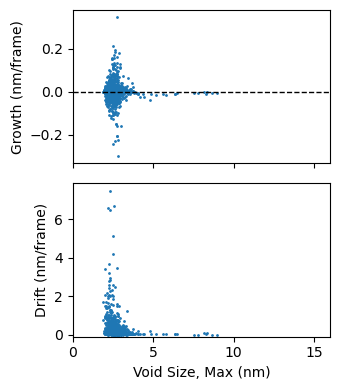

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 4.), sharex=True)

# Plot the void growth
ax = axs[0]
ax.scatter(void_tracks['max_radius'] * pixel_size, void_tracks['growth_rate'] * pixel_size, s=1)
ax.set_xlim(0, 16)
ax.plot(ax.get_xlim(), [0, 0], 'k--', lw=1)
ax.set_ylabel('Growth (nm/frame)')

# Plot the movement
ax = axs[1]
ax.scatter(void_tracks['max_radius'] * pixel_size, void_tracks['drift_rate'] * pixel_size, s=1)
ax.set_ylabel('Drift (nm/frame)')
ax.set_ylim(-0.1, max(ax.get_ylim()))

ax.set_xlabel('Void Size, Max (nm)')
fig.tight_layout()

fig.savefig(out_directory / 'figures/coarse-metrics.png', dpi=320)

Large voids continue to continue to grow, small ones will disappear. Drift (how much it moved from the start) is only noticable for the small voids

### Does that hold on at individual timesteps?
Can we look at specific snapshots in time and see if smaller voids are more mobile and less likely to grow.

Our strategy will be to fit a smoothing spline to the positions and radii, then estimate the derivatives at a few points along its timeline.

Start by examining a few voids

In [8]:
big_void = void_tracks.sort_values('max_radius', ascending=False).iloc[0]

In [9]:
medium_void = void_tracks.sort_values('max_radius', ascending=False).iloc[2]

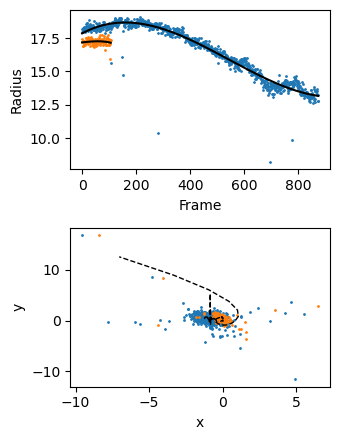

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 4.5), sharex=False)

for void in [big_void, medium_void]:
    # Plot the radius
    x = np.arange(void['total_frames']) + void['start_frame']
    spline = UnivariateSpline(x, void['radii'])
    axs[0].scatter(x, void['radii'], s=1)
    axs[0].plot(x, spline(x), 'k-')

    # Plot the x-z coordinates
    positions = np.array(void['positions'])
    positions -= positions[0, :]
    x_spline = UnivariateSpline(x, positions[:, 0], )
    y_spline = UnivariateSpline(x, positions[:, 1])
    axs[1].scatter(positions[:, 0], positions[:, 1], s=1)
    axs[1].plot(x_spline(x), y_spline(x), 'k--', lw=1)

# Axes
axs[0].set_xlabel('Frame')
axs[0].set_ylabel('Radius')

axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
fig.tight_layout()

The spline works well with its default settings for the radius. We probably need more smoothing for the y-splines

Repeat analysis for all voids then pick the derivatives at a few frames along the growth

In [11]:
snapshots = []
for _, void in void_tracks.query('total_frames > 48').iterrows():
    # Get the rates of changes of voids wrt time
    x = np.arange(void['total_frames'], dtype=int) + void['start_frame']
    r_spline = UnivariateSpline(x, void['radii'])
    m_spline = UnivariateSpline(x, void['disp_from_start']).derivative(1)
    
    # Get the x and y coordinates
    positions = np.array(void['positions'])
    x_spline = UnivariateSpline(x, positions[:, 0])
    y_spline = UnivariateSpline(x, positions[:, 1])
    
    # Compute the drift from the x and y prints
    start = [x_spline(void['start_frame']), y_spline(void['start_frame'])]
    positions_smoothed = np.transpose([x_spline(x), y_spline(x)])
    drift = np.linalg.norm(np.subtract(positions_smoothed, start), axis=1)
    drift_spline = UnivariateSpline(x, drift).derivative(1)
    
    # Measure it every 20 frames
    r_spline_dt = r_spline.derivative(1)
    for frame in x:
        snapshots.append({
            'void': void.name,
            'frame': frame,
            'radius': r_spline(frame) * pixel_size,
            'radius_dt': float(r_spline_dt(frame)) * pixel_size,
            'movement': m_spline(frame), 
            'drift_rate': np.linalg.norm([s(frame, 1) for s in [x_spline, y_spline]]) * pixel_size,
            'position-x': positions[frame - void['start_frame'], 0],
            'position-y': positions[frame - void['start_frame'], 1]
        })
snapshots = pd.DataFrame(snapshots).sample(frac=1)
print(f'Pulled {len(snapshots)} snapshots')

Pulled 27652 snapshots


Assign a random color to each void

In [12]:
cmap = colormaps['viridis']

In [13]:
colors = np.linspace(0, 1, len(void_tracks))
rng = np.random.RandomState(1)
rng.shuffle(colors)
colors = cmap(colors)

In [14]:
snapshots['color'] = snapshots['void'].apply(colors.__getitem__)

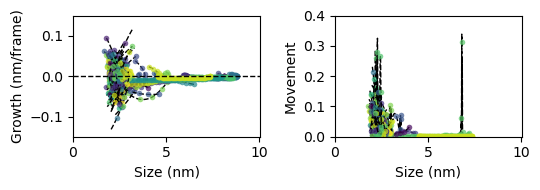

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.), sharex=True)

alpha = 0.7

# Plot the growth
ax = axs[0]
for gid, group in snapshots.groupby('void'):
    # Skip tracks outside the box
    if group['radius_dt'].abs().max() > 0.2:
        continue
    group = group.sort_values('frame')
    
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['radius'], group['radius_dt'], 'k--o', 
            ms=4, lw=1, mfc=color, mec='none', markevery=12)

ax.set_xlim(0, max(ax.get_xlim()) * 1.1)
ax.plot(ax.get_xlim(), [0, 0], 'k--', lw=1)
ax.set_ylabel('Growth (nm/frame)')
ax.set_ylim(-0.15, 0.15)

# Plot the movement
ax = axs[1]
for gid, group in snapshots.groupby('void'):
    # Skip tracks outside the box
    if group['drift_rate'].abs().max() > 0.4:
        continue
    group = group.sort_values('frame')
    
    # Determine the color for this group
    color = group['color'].iloc[0].tolist()
    color[3] = alpha  # Set the alpha
    ax.plot(group['radius'], group['drift_rate'], 'k--o', 
            ms=4, lw=1, mfc=color, mec='none', markevery=12)

ax.set_ylim(0, 0.4)
ax.set_ylabel('Movement')

for ax in axs:
    ax.set_xlabel('Size (nm)')
fig.tight_layout()
fig.savefig(out_directory / 'figures/time-resolved-voids.png', dpi=320)

Save the smoothed tracks

In [ ]:
snapshots.to_csv(out_directory / 'smoothed_tracks.csv')